In [1]:
from collections import deque
from imutils.video import VideoStream
import numpy as np
import cv2 
import imutils
import pandas as pd



Trackeo en base a un video, guardando los datos en un position.csv

In [2]:
# Definir el color a trackear en el espacio HSV
greenLower = (36, 148, 146)
greenUpper = (48, 244, 230)

# Crear un DataFrame para almacenar las posiciones y tiempos
position_df = pd.DataFrame()

# Abrir el video
vs = cv2.VideoCapture('VideoTR.mp4')

# Obtener el alto del frame (para ajustar el eje de coordenadas) y el framerate
_, frame = vs.read()
frame_height = frame.shape[0]
fps = vs.get(cv2.CAP_PROP_FPS)
print(fps)

# Calcular el tiempo real por cuadro en la vida real (cada segundo de video son 8 segundos en la vida real)
time_per_frame_real = 1 / (fps * 8)

# Inicializar contador de cuadros
frame_count = 0

# Loop que recorre el video cuadro a cuadro
while True:
    # Leer el siguiente cuadro
    _, frame = vs.read()

    # Si no hay más cuadros, romper el bucle
    if frame is None:
        break

    # Redimensionar el cuadro y aplicarle un desenfoque gaussiano
    frame = imutils.resize(frame, width=600)
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    # Crear la máscara para el rango de colores
    mask = cv2.inRange(hsv, greenLower, greenUpper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    # Encontrar contornos y determinar el centroide
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    center = None

   
    # Continuar si se encontraron contornos
    if len(cnts) > 0:
        c = max(cnts, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)

        # Asegurarse de que M["m00"] no sea cero para evitar errores de división
        if M["m00"] > 0:
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

            if radius > 10:
                # Dibujar círculo y centroide en el frame
                cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2)
                cv2.circle(frame, center, 5, (0, 0, 255), -1)

    # Solo guardar posiciones si center no es None
    if center is not None:
        # Cambiar el eje y restando el valor de y al alto del frame
        adjusted_center = (center[0], frame_height - center[1])

        # Calcular el tiempo real transcurrido
        time_real = frame_count * time_per_frame_real

        # Guardar la posición y el tiempo en el DataFrame
        position_df = pd.concat([position_df, pd.DataFrame({'x': [adjusted_center[0]], 'y': [adjusted_center[1]], 'time_real': [time_real]})], ignore_index=True)

    # Mostrar los cuadros
    cv2.imshow('Frame', frame)
    cv2.imshow('Mask', mask)

    # Incrementar contador de cuadros
    frame_count += 1

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

# Liberar el video y cerrar las ventanas
vs.release()
cv2.destroyAllWindows()

# Guardar las posiciones y tiempos en un archivo CSV
position_df.to_csv('positionUnPique.csv', index=False)



30.0


Pasaje de unidades y generación de gráficos.

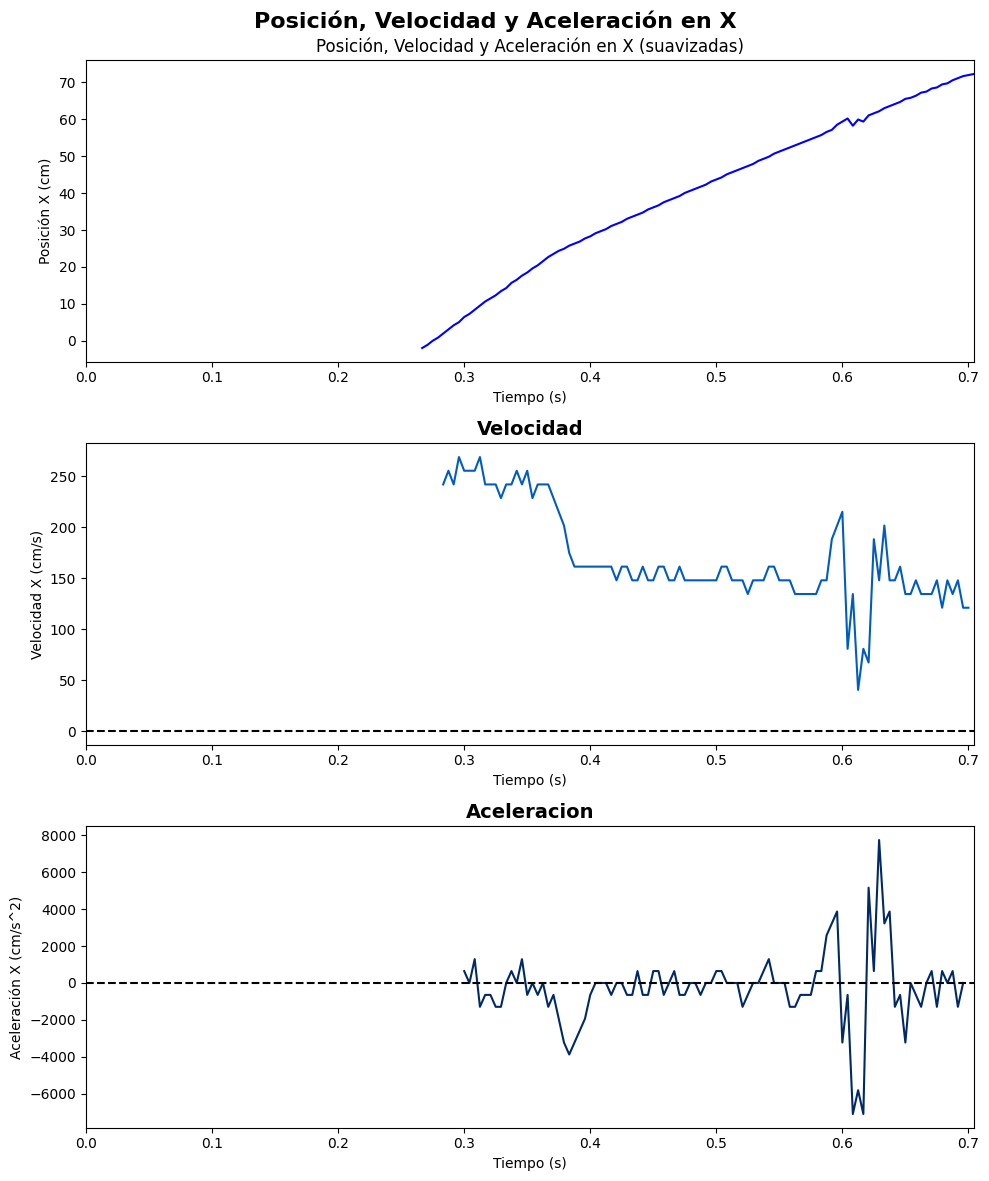

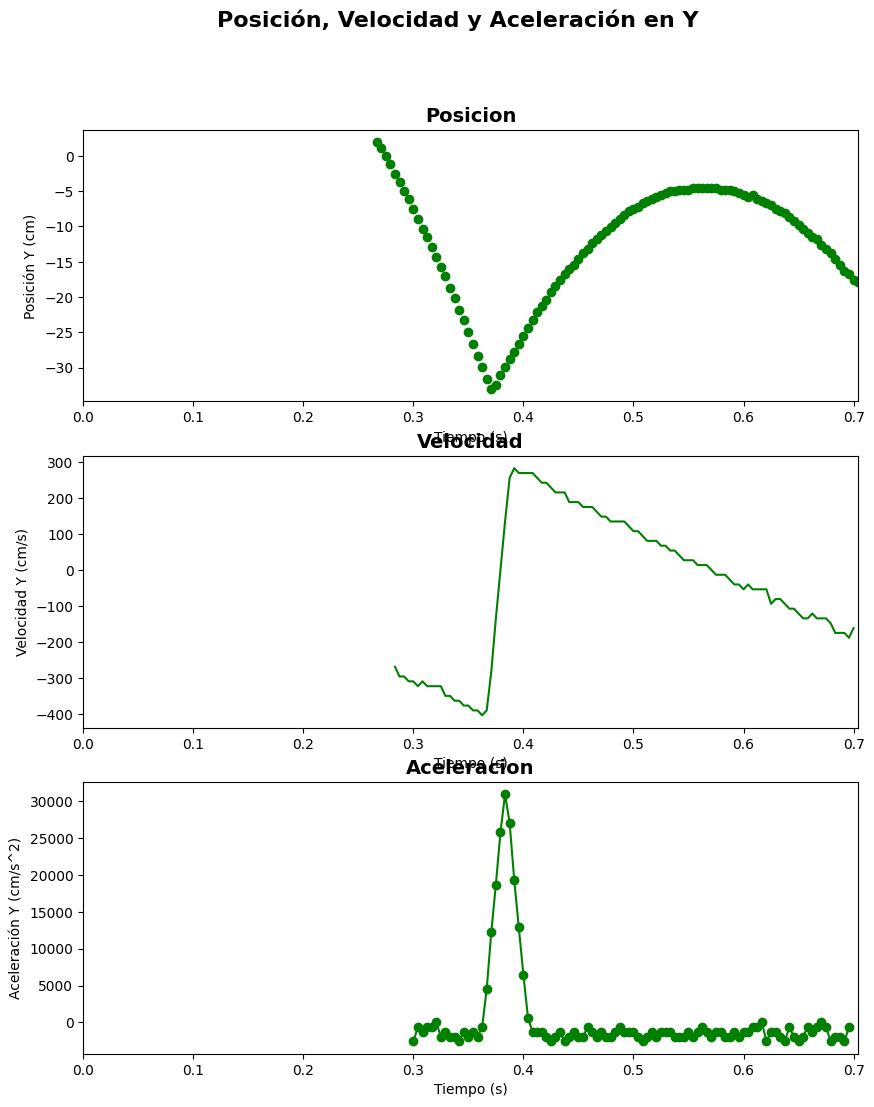

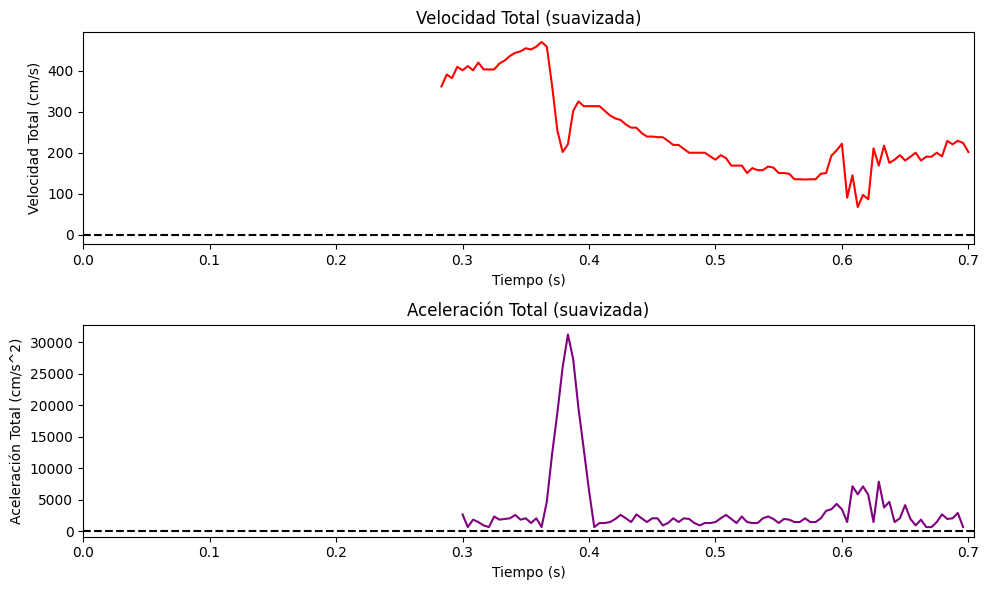

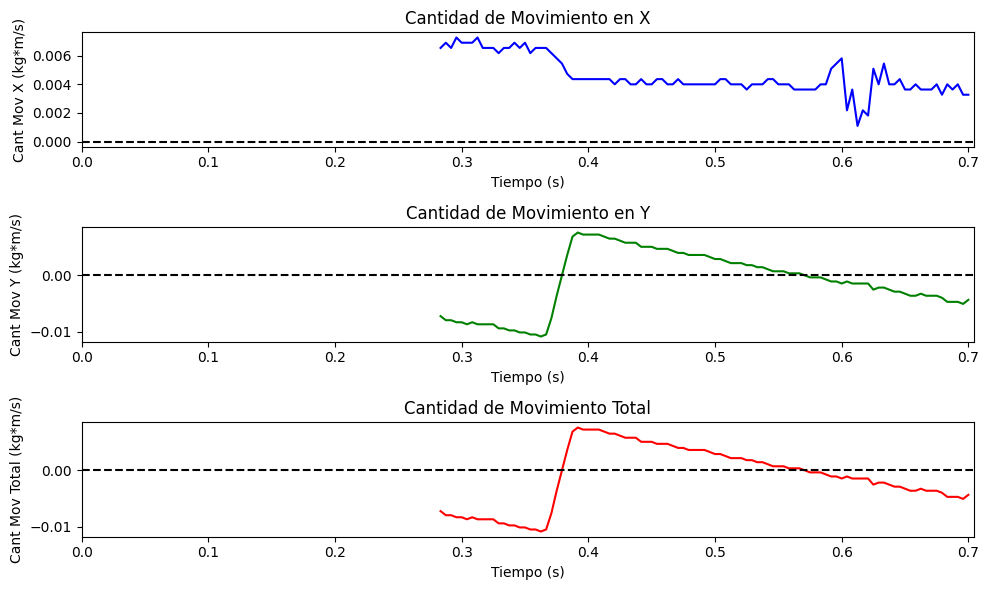

In [8]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import scipy.signal
from scipy.optimize import curve_fit
# Leer los datos desde position.csv
df = pd.read_csv('positionUnPique.csv')

# RELACION PIXEL-METRO.
# Las cajas miden 230 pixeles en el video, y sabemos que mide 64.8cm. Con estos datos calculamos.
pixel_to_cm = 0.28

# Convertir posiciones de pixeles a cm sin suavizado
init_x = df.iloc[2]['x']
init_y = df.iloc[2]['y']
df['x_cm'] = (df['x'] - init_x) * pixel_to_cm
df['y_cm'] = (df['y'] - init_y) * pixel_to_cm

# Definir el desfase temporal
SUAVIZADO = -1
window_size = 5  # Ajusta según lo que necesites

# Calcular el delta de tiempo (saltando un punto)
df['delta_time'] = df['time_real'].shift(SUAVIZADO) - df['time_real']

# Calcular las velocidades como la diferencia de posiciones dividida por el intervalo de tiempo
df['vx'] = (df['x_cm'].shift(SUAVIZADO) - df['x_cm']) / df['delta_time']
df['vy'] = (df['y_cm'].shift(SUAVIZADO) - df['y_cm']) / df['delta_time']

df['vx'] = df['vx'].rolling(window=window_size).mean()
df['vy'] = df['vy'].rolling(window=window_size).mean()

# Calcular la aceleración como la diferencia de velocidades dividida por el intervalo de tiempo
df['ax'] = (df['vx'].shift(SUAVIZADO) - df['vx']) / df['delta_time']
df['ay'] = (df['vy'].shift(SUAVIZADO) - df['vy']) / df['delta_time']

df['ax'] = df['ax'].rolling(window=window_size).mean()
df['ay'] = df['ay'].rolling(window=window_size).mean()

# Calcular la velocidad total (magnitud)
df['v_total'] = np.sqrt(df['vx']**2 + df['vy']**2)

# Calcular la aceleración total (magnitud)
df['a_total'] = np.sqrt(df['ax']**2 + df['ay']**2)

# CANTIDAD DE MOVIMIENTO
masa_pelota = 0.0027  # en kg
df['px'] = masa_pelota * (df['vx'] / 100)  # Porque df['vx'] está en cm/s  
df['py'] = masa_pelota * (df['vy'] / 100)  # Porque df['vy'] está en cm/s  

df['p_total'] = masa_pelota * (df['v_total'] / 100)  # v_total en cm/s, se divide por 100 para convertir a m/s

# Guardar los datos en un nuevo archivo CSV
df[['time_real', 'x_cm', 'y_cm', 'vx', 'vy', 'ax', 'ay', 'px', 'py', 'v_total', 'a_total']].to_csv('processed_data_un_pique_sin_suavizado.csv', index=False)

# Obtener los límites del tiempo
time_min = df['time_real'].min()
time_max = df['time_real'].max()

# Desfase temporal en segundos
delay = 0


#MINIMOS LOCALES POSICION
# Detectar los índices de los mínimos locales para la velocidad Y
minimos_indices_y = scipy.signal.argrelextrema(df['y_cm'].values, np.less)[0]

# Filtrar los mínimos donde la posicion Y sea menor a -20
minimos_indices_y_filtrados = [
    i for i in minimos_indices_y if df['y_cm'].values[i] < -20
]
minimos_tiempos_y_filtrados = df['time_real'].values[minimos_indices_y_filtrados]

#MINIMOS LOCALES VELOCIDAD
# Detectar los índices de los mínimos locales para la velocidad Y
minimos_indices_vy = scipy.signal.argrelextrema(df['vy'].values, np.less)[0]

# Filtrar los mínimos donde la velocidad Y sea menor a -20
minimos_indices_vy_filtrados = [
    i for i in minimos_indices_vy if df['vy'].values[i] < -20
]
minimos_tiempos_vy_filtrados = df['time_real'].values[minimos_indices_vy_filtrados]

# Gráfico 1: Posición, Velocidad y Aceleración en X en una sola imagen
plt.figure(figsize=(10, 12))
plt.suptitle('Posición, Velocidad y Aceleración en X', fontsize=16, fontweight='bold')

# Posición en X
plt.subplot(3, 1, 1)
plt.plot(df['time_real'], df['x_cm'], label='Posición X', color='blue')
plt.title('Posicion', fontsize=14, fontweight='bold') 
plt.title('Posición, Velocidad y Aceleración en X (suavizadas)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición X (cm)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

# Velocidad en X
vel_x_plot = np.where(df['time_real'] <= delay, 0, df['vx'])
plt.subplot(3, 1, 2)
plt.plot(df['time_real'] + delay, vel_x_plot, label='Velocidad X', color='#005cbf')
plt.axhline(y=0, color='k', linestyle='--') 
plt.title('Velocidad', fontsize=14, fontweight='bold') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad X (cm/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

# Aceleración en X
plt.subplot(3, 1, 3)
plt.plot(df['time_real'] + 1.5*delay, df['ax'], label='Aceleración X', color='#002966')
plt.axhline(y=0, color='k', linestyle='--') 
plt.title('Aceleracion', fontsize=14, fontweight='bold') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración X (cm/s^2)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

plt.tight_layout()
plt.show()

# Gráfico 2: Posición, Velocidad y Aceleración en Y en una sola imagen
plt.figure(figsize=(10, 12))
plt.suptitle('Posición, Velocidad y Aceleración en Y', fontsize=16, fontweight='bold')
# Posición en Y
plt.subplot(3, 1, 1)
plt.scatter(df['time_real'], df['y_cm'], label='Posición Y', color='green')
plt.title('Posicion', fontsize=14, fontweight='bold') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición Y (cm)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0
"""
# Marcar mínimos locales para posición Y
y_max = plt.ylim()[1]
for tiempo_minimo in minimos_tiempos_y_filtrados:
    plt.axvline(x=tiempo_minimo, color='red', linestyle='--', label='Mínimo local < -20')
    plt.text(tiempo_minimo, 1, f'{tiempo_minimo:.2f}s', color='black', ha='center', fontsize=15, fontweight='bold')
"""
# Velocidad en Y
vel_y_plot = np.where(df['time_real'] <= delay, 0, df['vy'])
plt.subplot(3, 1, 2)
plt.plot(df['time_real'] + delay, vel_y_plot, label='Velocidad Y', color='green')
plt.title('Velocidad', fontsize=14, fontweight='bold') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad Y (cm/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0
"""
# Marcar mínimos locales para velocidad Y
y_max = plt.ylim()[1]
for tiempo_minimo in minimos_tiempos_vy_filtrados:
    plt.axvline(x=tiempo_minimo + delay, color='red', linestyle='--', label='Mínimo local < -20')
    plt.text(tiempo_minimo + delay, 1, f'{tiempo_minimo + delay:.2f}s', color='black', ha='center', fontsize=15, fontweight='bold')
"""
# Aceleración en Y
plt.subplot(3, 1, 3)
plt.plot(df['time_real'] + 1.5*delay, df['ay'], '-o',label='Aceleración Y', color='green')
plt.title('Aceleracion', fontsize=14, fontweight='bold') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración Y (cm/s^2)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

"""
    # Marcar tiempos de los mínimos de la velocidad Y en el gráfico de aceleración
    #for tiempo_minimo in minimos_tiempos_vy_filtrados:
      #  plt.axvline(x=tiempo_minimo + delay, color='red', linestyle='--', label='Mínimo velocidad Y')
       # plt.text(tiempo_minimo + delay, 1, f'{tiempo_minimo + delay:.2f}s', color='black', ha='center', fontsize=15, fontweight='bold')

    #plt.tight_layout()
    #plt.show()

"""

# Gráfico 4: Velocidad total y Aceleración total en gráficos separados
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(df['time_real'] + delay, df['v_total'], label='Velocidad Total', color='red')
plt.title('Velocidad Total (suavizada)')
plt.axhline(y=0, color='k', linestyle='--') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad Total (cm/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

plt.subplot(2, 1, 2)
plt.plot(df['time_real']  + delay * 1.5, df['a_total'], label='Aceleración Total', color='purple')
plt.title('Aceleración Total (suavizada)')
plt.axhline(y=0, color='k', linestyle='--') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración Total (cm/s^2)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

plt.tight_layout()
plt.show()

# Gráfico 5: Cantidad de Movimiento respecto al tiempo
p_x_plot = np.where(df['time_real'] <= delay, 0, df['px'])
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(df['time_real'] + delay, p_x_plot, label='Cant Mov X', color='blue')
plt.axhline(y=0, color='k', linestyle='--') 
plt.title('Cantidad de Movimiento en X')
plt.xlabel('Tiempo (s)')
plt.ylabel('Cant Mov X (kg*m/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

p_y_plot = np.where(df['time_real'] <= delay, 0, df['py'])
plt.subplot(3, 1, 2)
plt.plot(df['time_real'] + delay, p_y_plot, label='Cant Mov Y', color='green')
plt.axhline(y=0, color='k', linestyle='--') 
plt.title('Cantidad de Movimiento en Y')
plt.xlabel('Tiempo (s)')
plt.ylabel('Cant Mov Y (kg*m/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0


p_total_plot = np.where(df['time_real'] <= delay, 0, df['py'])

plt.subplot(3, 1, 3)
plt.plot(df['time_real'] + delay, p_total_plot, label='Cant Mov Total', color='red')
plt.title('Cantidad de Movimiento Total')
plt.axhline(y=0, color='k', linestyle='--') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Cant Mov Total (kg*m/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

plt.tight_layout()
plt.show()







In [60]:
df.iloc[50:105, [5,6, 8, 9, 10, 11]]


x    y  time_real   x_cm   y_cm  delta_time      vx      vy  \
0    185  420   0.266667  -1.96   1.96    0.004167     NaN     NaN   
1    188  417   0.270833  -1.12   1.12    0.004167     NaN     NaN   
2    192  413   0.275000   0.00   0.00    0.004167     NaN     NaN   
3    195  409   0.279167   0.84  -1.12    0.004167     NaN     NaN   
4    199  404   0.283333   1.96  -2.52    0.004167  241.92 -268.80   
..   ...  ...        ...    ...    ...         ...     ...     ...   
101  444  358   0.687500  70.56 -15.40    0.004167  134.40 -174.72   
102  446  355   0.691667  71.12 -16.24    0.004167  147.84 -174.72   
103  448  353   0.695833  71.68 -16.80    0.004167  120.96 -188.16   
104  449  350   0.700000  71.96 -17.64    0.004167  120.96 -161.28   
105  450  349   0.704167  72.24 -17.92         NaN     NaN     NaN   

               ax            ay     v_total      a_total        px        py  \
0             NaN           NaN         NaN          NaN       NaN       NaN   
1             NaN           NaN         NaN          NaN       NaN       NaN   
2             NaN           NaN         NaN          NaN       NaN       NaN   
3             NaN           NaN         NaN          NaN       NaN       NaN   
4    3.225600e+03 -6.451200e+03  361.633414  7212.660868  0.006532 -0.007258   
..            ...           ...         ...          ...       ...       ...   
101  3.225600e+03 -1.432454e-10  220.432390  3225.600000  0.003629 -0.004717   
102 -6.451200e+03 -3.225600e+03  228.874953  7212.660868  0.003992 -0.004717   
103 -6.821210e-12  6.451200e+03  223.686180  6451.200000  0.003266 -0.005080   
104           NaN           NaN  201.600000          NaN  0.003266 -0.004355   
105           NaN           NaN         NaN          NaN       NaN       NaN   

      p_total  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4    0.009764  
..        ...  
101  0.005952  
102  0.006180  
103  0.006040  
104  0.005443  
105       NaN  

[106 rows x 15 columns]